<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/EZMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Load the MNIST test dataset
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)


Failed to download (trying next):
HTTP Error 502: Bad Gateway



100%|██████████| 9912422/9912422 [00:00<00:00, 15991242.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 55745832.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19683878.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12118656.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
import matplotlib.pyplot as plt

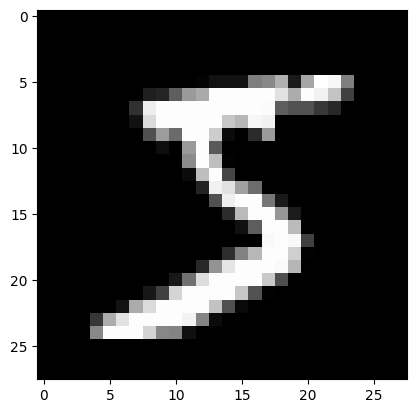

In [3]:
plt.imshow(mnist_train[0][0].view(28, 28), cmap='gray') # data science right here

In [4]:
mnist_train[0][1]

5

In [5]:
import torch.nn.functional as F

In [6]:
def cleanup(data):
  xs = []
  ys = []
  for d in data:
    # (in, num) to x and y
    xs.append(d[0])
    ys.append(F.one_hot(torch.tensor(d[1]), num_classes=10))
  return torch.stack(xs), torch.stack(ys)

Xtr, Ytr = cleanup(mnist_train)
Xte, Yte = cleanup(mnist_test)

In [7]:
train_len = len(Xtr)
train_len

60000

In [8]:
num_epochs = 10000
lr = 0.01
batch_size = 16

In [9]:
w1 = torch.randn((784, 100)) * 0.1
b1 = torch.randn(100) * 0.01
w2 = torch.randn((100, 70)) * 0.1
b2 = torch.randn(70) * 0.01
w3 = torch.randn((70, 10)) * 0.1
b3 = torch.randn(10) * 0.01
params = [w1, b1, w2, b2, w3, b3]
for p in params:
  p.requires_grad = True

In [10]:
for epoch in range(num_epochs):
  xin = torch.randint(train_len -1, (batch_size, ))
  inputs = Xtr[xin].view(batch_size, 784)
  wi1 = inputs @ w1
  wi1b = (wi1 + b1).tanh()
  wi2 = wi1b @ w2
  wi2b = (wi2 + b2).tanh()
  wi3 = wi2b @ w3
  out = (wi3 + b3).tanh()
  loss = ((Ytr[xin] - out)**2).mean()

  for p in params:
    p.grad = None

  loss.backward()

  for p in params:
    p.data -= p.grad * lr

  if epoch % 1000 == 0:
    print("loss:", loss.item())

inputs = Xtr.view(-1, 784)
wi1 = inputs @ w1
wi1b = (wi1 + b1).tanh()
wi2 = wi1b @ w2
wi2b = (wi2 + b2).tanh()
wi3 = wi2b @ w3
out = (wi3 + b3).tanh()
loss = ((Ytr - out)**2).mean()
print("train loss", loss.item())

inputs = Xte.view(-1, 784)
wi1 = inputs @ w1
wi1b = (wi1 + b1).tanh()
wi2 = wi1b @ w2
wi2b = (wi2 + b2).tanh()
wi3 = wi2b @ w3
out = (wi3 + b3).tanh()
loss = ((Yte - out)**2).mean()
print("test loss", loss.item())

loss: 0.18746814131736755
loss: 0.07920701056718826
loss: 0.06284866482019424
loss: 0.045428283512592316
loss: 0.05610272288322449
loss: 0.061810314655303955
loss: 0.04524793103337288
loss: 0.04849855601787567
loss: 0.03721059113740921
loss: 0.03544498607516289
train loss 0.04438776522874832
test loss 0.043615225702524185


In [16]:
test_len = len(Xte)

net prediction 8 actual tensor(8)


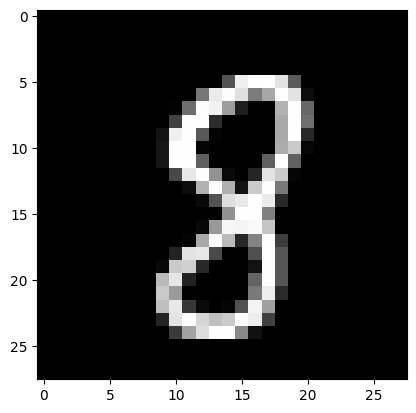

In [19]:
def forward(ins):
  inputs = ins.view(784)
  wi1 = inputs @ w1
  wi1b = (wi1 + b1).tanh()
  wi2 = wi1b @ w2
  wi2b = (wi2 + b2).tanh()
  wi3 = wi2b @ w3
  out = (wi3 + b3).tanh()
  return torch.argmax(out)

with torch.no_grad():
  index = torch.randint(test_len - 1, (1,))
  print("net prediction", forward(Xte[index]).item(), "actual", torch.argmax(Yte[index]))
  plt.imshow(Xte[index].view(28, 28), cmap='gray')


net prediction 3 actual tensor(8)


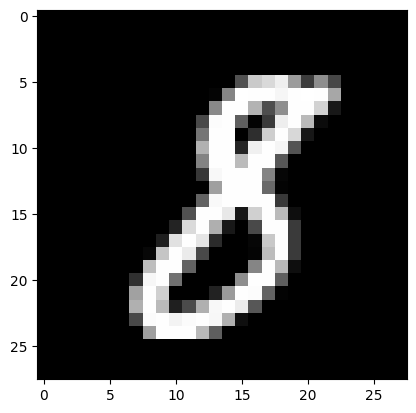

In [20]:
# wrong example
with torch.no_grad():
  correct = True
  while correct:
    index = torch.randint(test_len - 1, (1,))
    correct = (forward(Xte[index]).item() == torch.argmax(Yte[index]))
  print("net prediction", forward(Xte[index]).item(), "actual", torch.argmax(Yte[index]))
  plt.imshow(Xte[index].view(28, 28), cmap='gray')